<a href="https://colab.research.google.com/github/Mun-Robbery/NLP/blob/main/disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"antrisole","key":"f640a223d90f428a09658502f16db9e2"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [3]:
!kaggle competitions download -c nlp-getting-started


  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 55.4MB/s]


In [4]:
!unzip nlp-getting-started

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


#Load libs

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [20]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel,
                                                    ppb.DistilBertTokenizer,
                                                    'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

#Feature cleaning

In [7]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
import re

In [13]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [14]:
train_df['text']=train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text']=test_df['text'].apply(lambda x: remove_emoji(x))

In [15]:
import string

In [16]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [17]:
train_df['text']=train_df['text'].apply(lambda x: remove_punct(x))
test_df['text']=test_df['text'].apply(lambda x: remove_punct(x))

##Preproccessing

In [18]:
texts = train_df['text'].values
target = train_df['target'].values

In [50]:
from sklearn.model_selection import train_test_split
texts_train, texts_valid, y_train, y_valid = train_test_split(texts, target, test_size=0.3, random_state=42)

In [51]:
texts_train_tokenized = [tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True) for x in texts_train]# YOUR CODE HERE
texts_valid_tokenized = [tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True) for x in texts_valid] # YOUR CODE HERE

In [52]:
def pad_texts(texts_tokenized):
    max_len = 0
    for i in texts_tokenized:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in texts_tokenized])
    return padded

In [53]:
padded_train = pad_texts(texts_train_tokenized)
padded_valid = pad_texts(texts_valid_tokenized)

In [55]:
def attention_mask(padded_text):
    return np.where(padded_text != 0, 1, 0)

In [56]:
attention_mask_train = attention_mask(padded_train)
attention_mask_train.shape

(5329, 55)

In [57]:
attention_mask_valid = attention_mask(padded_valid)
attention_mask_valid.shape

(2284, 55)

In [58]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')# YOUR CODE HERE
device

device(type='cuda')

#Learning

In [59]:
model = model_class.from_pretrained(pretrained_weights)

In [60]:
model.eval()
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [61]:
import tqdm

In [65]:
texts_train.shape[0]

5329

In [66]:
output = []
batch_size = 16
for idx in tqdm.tnrange(0, texts_train.shape[0], batch_size):
  batch = torch.tensor(padded_train[idx:idx+batch_size]).to(device)
  local_attention_mask = torch.tensor(attention_mask_train[idx:idx+batch_size]).to(device)

  with torch.no_grad():
    last_hidden_states = model(batch, attention_mask = local_attention_mask)[0][:,0,:].cpu().numpy()
    output.append(last_hidden_states)

  0%|          | 0/334 [00:00<?, ?it/s]

In [77]:
output_valid = []
batch_size = 16
for idx in tqdm.tnrange(0, texts_valid.shape[0], batch_size):
  batch = torch.tensor(padded_valid[idx:idx+batch_size]).to(device)
  local_attention_mask = torch.tensor(attention_mask_valid[idx:idx+batch_size]).to(device)

  with torch.no_grad():
    last_hidden_states = model(batch, attention_mask = local_attention_mask)[0][:,0,:].cpu().numpy()
    output_valid.append(last_hidden_states)

  0%|          | 0/143 [00:00<?, ?it/s]

In [84]:
train_features = np.vstack(output)
valid_features = np.vstack(output_valid)

In [85]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, y_train)

LogisticRegression()

In [99]:
lr_clf.score(valid_features, y_valid)

0.8134851138353766

In [87]:
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt

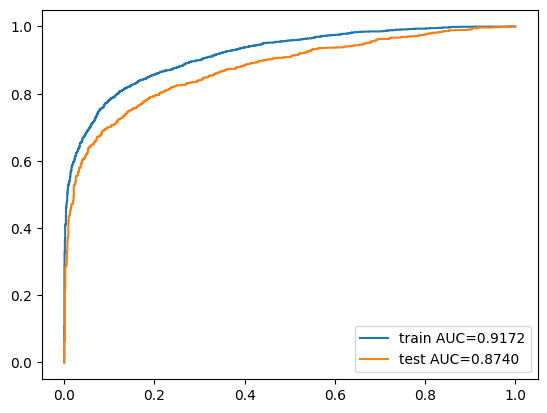

In [88]:
proba = lr_clf.predict_proba(train_features)[:, 1]

auc = roc_auc_score(y_train, proba)
plt.plot(*roc_curve(y_train, proba)[:2], label='%s AUC=%.4f' % ('train', auc))

proba = lr_clf.predict_proba(valid_features)[:, 1]
auc = roc_auc_score(y_valid, proba)
plt.plot(*roc_curve(y_valid, proba)[:2], label='%s AUC=%.4f' % ('test', auc))
plt.legend()

#Predict

In [90]:
texts_test_tokenized = [tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True) for x in test_df['text']] # YOUR CODE HERE

In [93]:
def pad_texts(texts_tokenized):

    padded = np.array([i + [0]*(55-len(i)) for i in texts_tokenized])
    return padded

In [95]:
padded_test = pad_texts(texts_test_tokenized)

In [97]:
attention_mask_test = attention_mask(padded_test)
attention_mask_test.shape

(3263, 55)

In [110]:
output_test = []
batch_size = 16
for idx in tqdm.tnrange(0, test_df.shape[0], batch_size):
  batch = torch.tensor(padded_test[idx:idx+batch_size]).to(device)
  local_attention_mask = torch.tensor(attention_mask_test[idx:idx+batch_size]).to(device)

  with torch.no_grad():
    last_hidden_states = model(batch, attention_mask = local_attention_mask)[0][:,0,:].cpu().numpy()
    output_test.append(last_hidden_states)

  0%|          | 0/204 [00:00<?, ?it/s]

In [111]:
test_features = np.vstack(output_test)

In [112]:
proba = lr_clf.predict_proba(test_features)

In [116]:
test_df.shape[0] == len(proba[:, 1])

True

3263

In [117]:
predicts = lr_clf.predict(test_features)

In [118]:
predicts

array([1, 1, 1, ..., 1, 1, 1])

In [121]:
submission = pd.DataFrame({
        "id": test_df['id'],
        "target": predicts
    })
submission.to_csv('disaster_1.csv', index=False)